In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/sop-covid/voice/model_rnn/cough

/content/drive/MyDrive/sop-covid/voice/model_rnn/cough


In [4]:
!unzip ../../data_rnn/data_cough.zip

Archive:  ../../data_rnn/data_cough.zip
   creating: data_cough/
  inflating: data_cough/valid_y.npy  
  inflating: data_cough/valid_X.npy  
  inflating: data_cough/test_y.npy   
  inflating: data_cough/test_X.npy   
  inflating: data_cough/train_y.npy  
  inflating: data_cough/train_X.npy  


In [53]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pickle
import os

import sys
sys.path.append('..')

from utils import *

In [54]:
SEED = 1
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [55]:
train_X = np.load(os.path.join('data_cough', 'train_X.npy'))
train_y = np.load(os.path.join('data_cough', 'train_y.npy'))

valid_X = np.load(os.path.join('data_cough', 'valid_X.npy'))
valid_y = np.load(os.path.join('data_cough', 'valid_y.npy'))

test_X = np.load(os.path.join('data_cough', 'test_X.npy'))
test_y = np.load(os.path.join('data_cough', 'test_y.npy'))

In [56]:
sc = Scaler()
sc.fit(train_X, (0, 1))

train_X_n = sc.transform(train_X, 'normalize')
train_X_s = sc.transform(train_X, 'standardize')

valid_X_n = sc.transform(valid_X, 'normalize')
valid_X_s = sc.transform(valid_X, 'standardize')

test_X_n = sc.transform(test_X, 'normalize')
test_X_s = sc.transform(test_X, 'standardize')

In [72]:
# Undersampling the majority class to make the distribution 50:50.
train_X_n_under = train_X[:int(2 * train_y.sum())]
train_y_under = train_y[:int(2 * train_y.sum())]

valid_X_n_under = valid_X[:int(2 * valid_y.sum())]
valid_y_under = valid_y[:int(2 * valid_y.sum())]

test_X_n_under = test_X[:int(2 * test_y.sum())]
test_y_under = test_y[:int(2 * test_y.sum())]

In [58]:
# Hyperparameters
learning_rate = 1e-4
epochs = 100
batch_size = 256

In [59]:
# Callback for early stopping
es_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    restore_best_weights=True
)

# Callback for reducing learning rate on loss plateauing
plateau_callback = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=0.0001
)

In [60]:
metrics = [
           keras.metrics.BinaryAccuracy(name='acc'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc'),
           keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn')
]

In [61]:
model = keras.Sequential([
    keras.layers.LSTM(64, activation='tanh', return_sequences=True, input_shape=train_X.shape[1:]),
    keras.layers.LSTM(64, activation='tanh', return_sequences=False),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

In [62]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss='binary_crossentropy',
    metrics=metrics
)

In [63]:
%%script echo "Comment line with %%script echo to run this cell."

history = model.fit(
    train_X_n_under,
    train_y_under,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(valid_X_n_under, valid_y_under),
    callbacks=[es_callback, plateau_callback],
    shuffle=True
)

Epoch 1/100
2/2 [==============================] - 1s 685ms/step - loss: 0.6947 - acc: 0.4507 - precision: 0.4352 - recall: 0.3310 - auc: 0.4672 - tp: 47.0000 - fp: 61.0000 - tn: 81.0000 - fn: 95.0000 - val_loss: 0.6921 - val_acc: 0.4167 - val_precision: 0.3846 - val_recall: 0.2778 - val_auc: 0.4691 - val_tp: 5.0000 - val_fp: 8.0000 - val_tn: 10.0000 - val_fn: 13.0000
Epoch 2/100
2/2 [==============================] - 0s 121ms/step - loss: 0.6922 - acc: 0.4930 - precision: 0.4898 - recall: 0.3380 - auc: 0.5164 - tp: 48.0000 - fp: 50.0000 - tn: 92.0000 - fn: 94.0000 - val_loss: 0.6922 - val_acc: 0.3889 - val_precision: 0.3889 - val_recall: 0.3889 - val_auc: 0.4784 - val_tp: 7.0000 - val_fp: 11.0000 - val_tn: 7.0000 - val_fn: 11.0000
Epoch 3/100
2/2 [==============================] - 0s 122ms/step - loss: 0.6915 - acc: 0.5106 - precision: 0.5094 - recall: 0.5704 - auc: 0.5312 - tp: 81.0000 - fp: 78.0000 - tn: 64.0000 - fn: 61.0000 - val_loss: 0.6913 - val_acc: 0.4444 - val_precision: 0.4

In [64]:
%%script echo "Comment line with %%script echo to run this cell."

model.save('lstm.h5')

In [65]:
%%script echo "Comment line with %%script echo to run this cell."

with open('lstm_history.pickle', 'wb') as f:
    pickle.dump(history.history, f)

In [66]:
model = keras.models.load_model('lstm.h5')

In [67]:
with open('lstm_history.pickle', 'rb') as f:
    history = pickle.load(f)

In [73]:
model.predict(test_X_n_under)

array([[0.8140611 ],
       [0.8386208 ],
       [0.8598409 ],
       [0.7109096 ],
       [0.79987   ],
       [0.45615512],
       [0.7236165 ],
       [0.79000455],
       [0.74157524],
       [0.22789374],
       [0.81928647],
       [0.8326762 ],
       [0.8361027 ],
       [0.2515445 ],
       [0.76707697],
       [0.87178296],
       [0.5601199 ],
       [0.5601199 ],
       [0.10626857],
       [0.745017  ],
       [0.14088067],
       [0.1402874 ],
       [0.11229039],
       [0.11529986],
       [0.09036164],
       [0.24526931],
       [0.8391022 ],
       [0.7762219 ],
       [0.21327531],
       [0.83592653],
       [0.83601636],
       [0.23652919],
       [0.1068561 ],
       [0.11705742],
       [0.10236919],
       [0.11009344]], dtype=float32)

In [75]:
model.evaluate(test_X_n_under, test_y_under)

2/2 [==============================] - 0s 49ms/step - loss: 0.5009 - acc: 0.7778 - precision: 0.7500 - recall: 0.8333 - auc: 0.8025 - tp: 15.0000 - fp: 5.0000 - tn: 13.0000 - fn: 3.0000


[0.5009286403656006,
 0.7777777910232544,
 0.75,
 0.8333333134651184,
 0.8024691939353943,
 15.0,
 5.0,
 13.0,
 3.0]

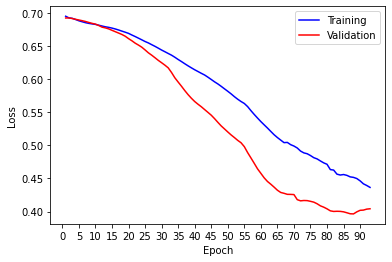

In [76]:
plt.plot(
    np.arange(1, len(history['loss']) + 1),
    history['loss'],
    color='b',
    label='Training'
)
plt.plot(
    np.arange(1, len(history['val_loss']) + 1),
    history['val_loss'],
    color='r',
    label='Validation'
)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, len(history['loss']) + 1, 5))
plt.legend()

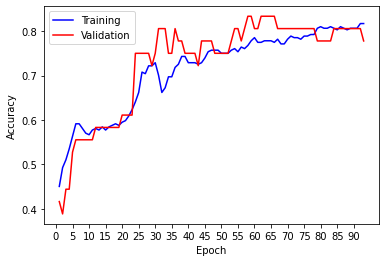

In [77]:
plt.plot(
    np.arange(1, len(history['acc']) + 1),
    history['acc'],
    color='b',
    label='Training'
)
plt.plot(
    np.arange(1, len(history['val_acc']) + 1),
    history['val_acc'],
    color='r',
    label='Validation'
)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(np.arange(0, len(history['loss']) + 1, 5))
plt.legend()